In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm

from sklearn.neighbors import NearestNeighbors

from textwrap import wrap
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
%matplotlib inline

## Generate Sampling Maps

In [2]:
# Generate sampling locations
def generate_polar_map(diam, num_radii, angular_density):
    """Returns arrays containing cartesian coordinates (X, Y) and polar coordinates (R, Theta) of a polar sampling map.
    
    Args:
        diam (float): outer diameter of the polar map
        num_radii (int): number of sampling radii, including center and outer edge
        angular_density (int): density of points on each radius.
                               Number of points for a give radius is
                               R0(center): 1 point
                               R1(1st radius): 1 * angular_density points
                               R2(2nd radius): 2 * angular_density points
                               ...
                               Rn(nth radius): n * angular_density points
    
    Returns:
        X (ndarray): 1D array of x coordinates
        Y (ndarray): 1D array of y coordinates
        R (ndarray): 1D array of radii
        Theta (ndarray): 1D array of polar angles
    """
    X = np.array([0.])  # initialize X coordinates with center point
    Y = np.array([0.])  # initialize Y coordinates with center point
    R = np.array([0.])  # initialize R coordinates with center point
    Theta = np.array([0.])  # initialize Theta coordinates with center point

    # loop through radii and append to X, Y coordinates
    for n, radius in enumerate(np.linspace(0, diam / 2, num_radii)):
        if n == 0:
            continue   # skip center point that has already been added at initialization
        
        num_points = angular_density * n  # number of sampling points on this radius
        angles = np.radians(np.linspace(0, 360 * (1 - 1 / num_points), num_points))  # ensure not to count 0/360deg twice
        X = np.append(X, np.round(radius * np.cos(angles), 2))
        Y = np.append(Y, np.round(radius * np.sin(angles), 2))
        R = np.append(R, np.repeat(radius, num_points))
        Theta = np.append(Theta, np.round(np.degrees(angles), 2))
                            
    return X, Y, R, Theta

Map contains 625 points


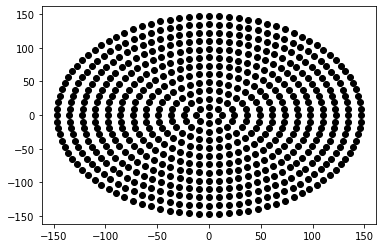

In [3]:
# Test generate_polar_map(). Map with 13 radii and density_factor=8 should have 625 points
X, Y, R, Theta = generate_polar_map(diam=294, num_radii=13, angular_density=8)
print('Map contains {} points'.format(len(X)))
plt.plot(X, Y, 'o', color='black')

## Generate Thickness Patterns

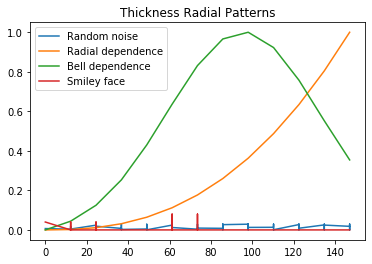

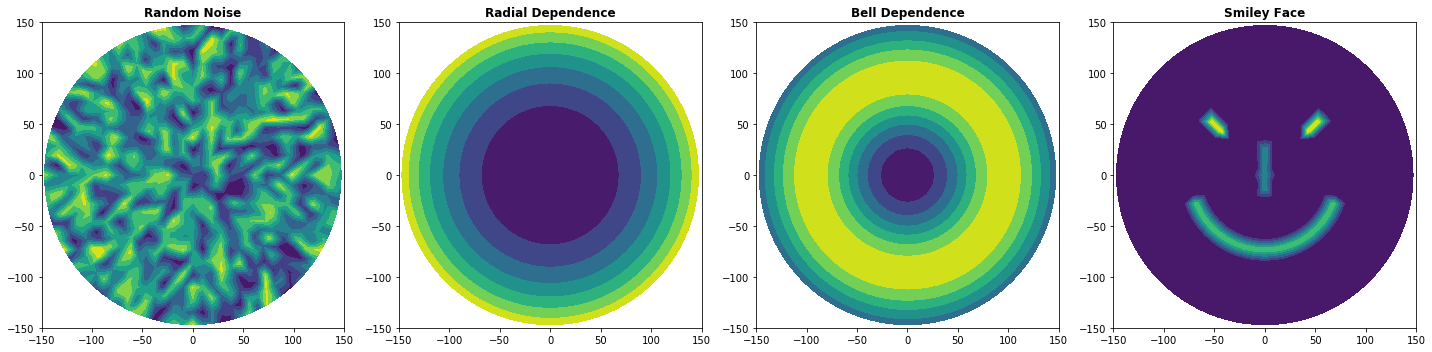

In [17]:
# Map
X, Y, R, Theta = generate_polar_map(294, 13, 8)  # 625-point map

# Thickness data trends
random_noise_amplitude = 0.03
radial_amplitude = 1
hidden_pattern_amplitude = 0.08



random_noise = np.random.rand(X.shape[0]) * random_noise_amplitude
radial_dependence = np.power(R / 147, 2.5) * radial_amplitude
norm_d = norm.pdf(R, R.max() * 0.65, R.max() / 4)
norm_d_scaled = norm_d / norm_d.max()
norm_d_shifted = norm_d_scaled - norm_d_scaled.min()
bell_dependence = norm_d_shifted / norm_d_shifted.max()

# Smiley face pattern
def face_map(row, amplitude):
    if 61.25 <= row['R'] <= 73.5 and (130 <= row['Theta'] <= 140 or 40 <= row['Theta'] <= 50): # eyes
        return amplitude
    elif 200 <= row['Theta'] <=340 and row['R'] == 73.5: # smile
        return 0.75 * amplitude
    elif abs(row['X']) < 2 and -12.25 <= row['Y'] <= 24.5:  # nose
        return 0.5 * amplitude
    else:
        return 0
smiley_face = pd.DataFrame({'X': X, 'Y': Y, 'R': R, 'Theta': Theta}).apply(face_map, axis=1, args=(hidden_pattern_amplitude,))

# Radial dependence plots
plt.plot(R, random_noise)
plt.plot(R, radial_dependence)
plt.plot(R, bell_dependence)
plt.plot(R, smiley_face)
plt.title('Thickness Radial Patterns')
plt.legend(['Random noise', 'Radial dependence', 'Bell dependence', 'Smiley face'])

# Contour plots
fig1 = plt.figure(figsize=(20, 5))
fig1.subplots_adjust(top=0.8)
ax1 = plt.subplot2grid((1, 4), (0, 0))
ax2 = plt.subplot2grid((1, 4), (0, 1))
ax3 = plt.subplot2grid((1, 4), (0, 2))
ax4 = plt.subplot2grid((1, 4), (0, 3))
ax1.set_title('Random Noise', fontweight='bold')
ax2.set_title('Radial Dependence', fontweight='bold')
ax3.set_title('Bell Dependence', fontweight='bold')
ax4.set_title('Smiley Face', fontweight='bold')

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlim([-150, 150])
    ax.set_ylim([-150, 150])
ax1.tricontourf(X, Y, random_noise)
ax2.tricontourf(X, Y, radial_dependence)
ax3.tricontourf(X, Y, bell_dependence)
ax4.tricontourf(X, Y, smiley_face)
plt.tight_layout()

# Generate Sample Thickness Data Sets

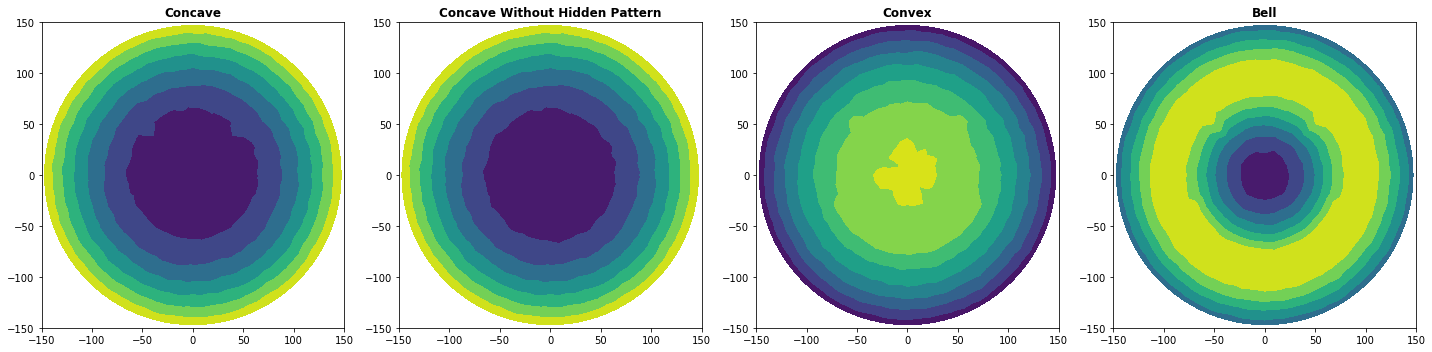

In [18]:
data_concave = pd.DataFrame({'X': X, 'Y': Y, 'R': R, 'Theta': Theta,
                             'Thickness': random_noise + radial_dependence + smiley_face})
data_concave_nohidden = pd.DataFrame({'X': X, 'Y': Y, 'R': R, 'Theta': Theta,
                             'Thickness': random_noise + radial_dependence})
data_convex = pd.DataFrame({'X': X, 'Y': Y, 'R': R, 'Theta': Theta,
                             'Thickness': random_noise - radial_dependence + smiley_face})
data_convex_nohidden = pd.DataFrame({'X': X, 'Y': Y, 'R': R, 'Theta': Theta,
                             'Thickness': random_noise - radial_dependence})
data_bell = pd.DataFrame({'X': X, 'Y': Y, 'R': R, 'Theta': Theta,
                             'Thickness': random_noise + bell_dependence + smiley_face})
data_bell_nohidden = pd.DataFrame({'X': X, 'Y': Y, 'R': R, 'Theta': Theta,
                             'Thickness': random_noise + bell_dependence})

# Contour plots
fig2 = plt.figure(figsize=(20, 5))
fig2.subplots_adjust(top=0.8)
ax5 = plt.subplot2grid((1, 4), (0, 0))
ax6 = plt.subplot2grid((1, 4), (0, 1))
ax7= plt.subplot2grid((1, 4), (0, 2))
ax8 = plt.subplot2grid((1, 4), (0, 3))
ax5.set_title('Concave', fontweight='bold')
ax6.set_title('Concave Without Hidden Pattern', fontweight='bold')
ax7.set_title('Convex', fontweight='bold')
ax8.set_title('Bell', fontweight='bold')

for ax in [ax5, ax6, ax7, ax8]:
    ax.set_xlim([-150, 150])
    ax.set_ylim([-150, 150])
ax5.tricontourf(X, Y, data_concave.Thickness)
ax6.tricontourf(X, Y, data_concave_nohidden.Thickness)
ax7.tricontourf(X, Y, data_convex.Thickness)
ax8.tricontourf(X, Y, data_bell.Thickness)
plt.tight_layout()


# Save to csv
data_concave.to_csv('concave.csv')
data_concave_nohidden.to_csv('concave_nohidden.csv')
data_convex.to_csv('convex.csv')
data_convex_nohidden.to_csv('convex_nohidden.csv')
data_bell.to_csv('bell.csv')
data_bell_nohidden.to_csv('bell_nohidden.csv')

In [31]:
def shepards_weights(distances, power=0):
    """Returns Shepards inverse distance weights for input distances
       wi = 1 / (d0, di) ** power
       
    Args:
        distances ([float]): distances from point to its neighbors
        power (float): Shepards power parameter
        
    Returns:
        [float]: Shepards inverse distance weights
    """
    return [1 / (d ** power) if d != 0 else 1 for d in distances]


def local_deviation_transform(data, x_colname='X', y_colname='Y', values_colname='Thickness',
                              radius=20, dist_sensitivity=3):
    """Adds column to input data with a transforms of input values to deviation 
       from surrounding neighborhood weighted value --> LDT = value - neighborhood_weighted_value
    
    Args:
        data (pandas.dataFrame): dataFrame containing map coordinates and values to be transformed
        x_colname (str): X coordinates column name
        y_colname (str): Y coordinates column name
        values_colname (str): Values column name
        radius (float): local neighborhood radius
        dist_sensitivity (float): Shepards inverse distance weighting power parameter
                                  weighti = 1 / (d0, di) ** dist_sensitivity, where d is distance
    """
    values = data[values_colname]
    deviation = np.zeros(values.shape)
    coordinates = np.array([[x, y] for x, y in zip(data[x_colname], data[y_colname])])
        
    # find nearest coordinate neighbors
    nbrs = NearestNeighbors().fit(coordinates)
    nbr_distances, nbr_indices = nbrs.radius_neighbors(coordinates, radius=radius)
    
    for idx, value in enumerate(values):
        # calculate neighborhood mean value
        nbr_weights = shepards_weights(nbr_distances[idx], power=dist_sensitivity)
        nbr_values = values[nbr_indices[idx]]
        neighborhood_weighted_value = np.dot(nbr_weights, nbr_values) / np.sum(nbr_weights)
        deviation[idx] =(value - neighborhood_weighted_value)
    
    data['LDT'] = deviation

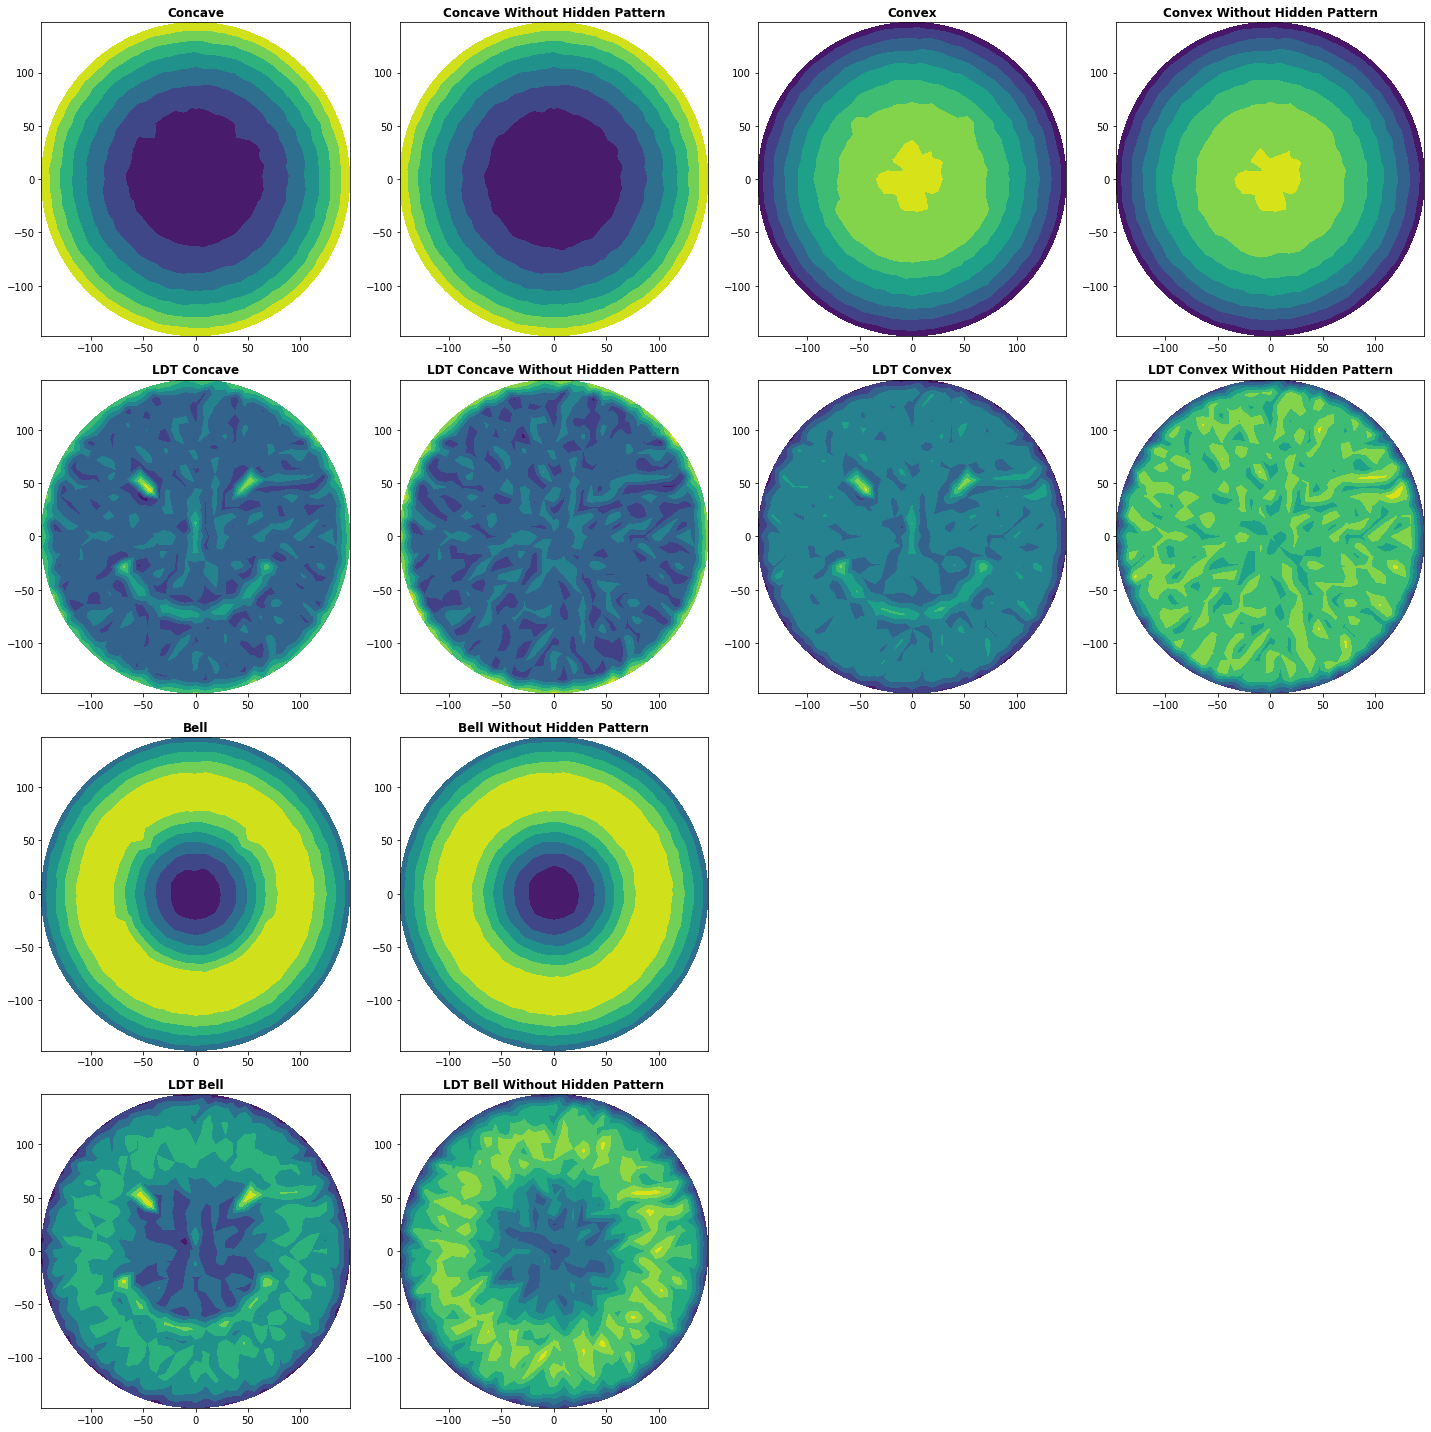

In [32]:
# Perform local deviation transformations on the datasets
local_deviation_transform(data_concave)
local_deviation_transform(data_concave_nohidden)
local_deviation_transform(data_convex)
local_deviation_transform(data_convex_nohidden)
local_deviation_transform(data_bell)
local_deviation_transform(data_bell_nohidden)

# Contour plots
fig3 = plt.figure(figsize=(20, 20))
fig3.subplots_adjust(top=0.8)
ax9 = plt.subplot2grid((4, 4), (0, 0))
ax10 = plt.subplot2grid((4, 4), (0, 1))
ax11= plt.subplot2grid((4, 4), (0, 2))
ax12 = plt.subplot2grid((4, 4), (0, 3))
ax13= plt.subplot2grid((4, 4), (1, 0))
ax14 = plt.subplot2grid((4, 4), (1, 1))
ax15= plt.subplot2grid((4, 4), (1, 2))
ax16 = plt.subplot2grid((4, 4), (1, 3))
ax17 = plt.subplot2grid((4, 4), (2, 0))
ax18 = plt.subplot2grid((4, 4), (2, 1))
ax19 = plt.subplot2grid((4, 4), (3, 0))
ax20 = plt.subplot2grid((4, 4), (3, 1))
ax9.set_title('Concave', fontweight='bold')
ax10.set_title('Concave Without Hidden Pattern', fontweight='bold')
ax11.set_title('Convex', fontweight='bold')
ax12.set_title('Convex Without Hidden Pattern', fontweight='bold')
ax13.set_title('LDT Concave', fontweight='bold')
ax14.set_title('LDT Concave Without Hidden Pattern', fontweight='bold')
ax15.set_title('LDT Convex', fontweight='bold')
ax16.set_title('LDT Convex Without Hidden Pattern', fontweight='bold')
ax17.set_title('Bell', fontweight='bold')
ax18.set_title('Bell Without Hidden Pattern', fontweight='bold')
ax19.set_title('LDT Bell', fontweight='bold')
ax20.set_title('LDT Bell Without Hidden Pattern', fontweight='bold')

ax9.tricontourf(X, Y, data_concave.Thickness)
ax10.tricontourf(X, Y, data_concave_nohidden.Thickness)
ax11.tricontourf(X, Y, data_convex.Thickness)
ax12.tricontourf(X, Y, data_convex_nohidden.Thickness)
ax13.tricontourf(X, Y, data_concave.LDT)
ax14.tricontourf(X, Y, data_concave_nohidden.LDT)
ax15.tricontourf(X, Y, data_convex.LDT)
ax16.tricontourf(X, Y, data_convex_nohidden.LDT)
ax17.tricontourf(X, Y, data_bell.Thickness)
ax18.tricontourf(X, Y, data_bell_nohidden.Thickness)
ax19.tricontourf(X, Y, data_bell.LDT)
ax20.tricontourf(X, Y, data_bell_nohidden.LDT)
plt.tight_layout()